<a href="https://colab.research.google.com/github/DIPANJAN001/Forecasting-Solar-Energy/blob/master/bestresult03newopt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install Boruta
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import concatenate
from keras import Model
from keras.layers import Input
from keras.layers import Bidirectional
from keras import layers
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_classification
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import LeakyReLU
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import load_model
from keras.layers import Input
from sklearn.decomposition import PCA 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def lstm_data_transform(x_data, y_data, num_steps):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [ ]:
df=pd.read_excel("/content/pv_03.xlsx")
weather_input1=df.drop('power_normed',axis=1)
weather_input=weather_input1.drop('time_idx',axis=1)
solpow=df['power_normed']

In [ ]:
rfc = RandomForestRegressor(random_state=1, n_estimators=1000, max_depth=7)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(np.array(weather_input), np.array(solpow)) 

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	49
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	8
Rejected: 	30
Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	8
Rejected: 	30
Iteration: 	10 / 100
Confirmed: 	11
Tentative: 	8
Rejected: 	30
Iteration: 	11 / 100
Confirmed: 	11
Tentative: 	8
Rejected: 	30
Iteration: 	12 / 100
Confirmed: 	11
Tentative: 	8
Rejected: 	30
Iteration: 	13 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	31
Iteration: 	14 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	31
Iteration: 	15 / 100
Confirmed: 	11
Tentative: 	7
Rejected: 	31
Iteration: 	16 / 100
Confirmed: 	11
Tentative: 	5
Reject

BorutaPy(estimator=RandomForestRegressor(max_depth=7, n_estimators=80,
                                         random_state=RandomState(MT19937) at 0x7F95BF980840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F95BF980840, verbose=2)

In [ ]:
X_important_train = boruta_selector.transform(np.array(weather_input))
num_steps = 3
# training set
(x_transformed_train,
 y_transformed_train) = lstm_data_transform(X_important_train,solpow , num_steps=num_steps)
assert x_transformed_train.shape[0] == y_transformed_train.shape[0]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_transformed_train,y_transformed_train,test_size=0.25, random_state=42,shuffle=False)
#X_train_,X_val,y_train_,y_val=train_test_split(X_train,y_train,test_size=0.2, random_state=42,shuffle=False)
inputs1 = Input(shape=(X_train.shape[1],X_train.shape[2]))

In [ ]:
inputs1

<KerasTensor: shape=(None, 3, 14) dtype=float32 (created by layer 'input_4')>

In [ ]:
from keras import optimizers

In [ ]:
opt=optimizers.Adam(learning_rate=0.003)

In [ ]:
from keras.layers import Bidirectional

In [ ]:
from keras import optimizers

class CustomAdam(optimizers.Adam):
    def __init__(self, new_idea_param=0.1, *args, **kwargs):
        self.new_idea_param = new_idea_param
        super(CustomAdam, self).__init__(*args, **kwargs)

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))

        new_idea_t = self.new_idea_param * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon) - new_idea_t * g

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            self.updates.append(K.update(p, p_t))
        return self.updates

In [ ]:
from keras import optimizers

class GradientAdam(optimizers.Adam):
    def __init__(self, gradient_param=0.1, *args, **kwargs):
        self.gradient_param = gradient_param
        super(GradientAdam, self).__init__(*args, **kwargs)

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) / (1. - K.pow(self.beta_1, t)))

        gradient_t = self.gradient_param * grads

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v, g_t in zip(params, grads, ms, vs, gradient_t):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon) + g_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            self.updates.append(K.update(p, p_t))
        return self.updates


In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops import math_ops

class HalvAdam(Adam):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prev_gradients = None

    @tf.function
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [math_ops.cast(x, "float32") for x in grads]

        if self.prev_gradients is not None:
            for i in range(len(grads)):
                if (grads[i] * self.prev_gradients[i] < 0):
                    self.updates[i] = self.updates[i] / 2

        self.prev_gradients = grads
        return self.updates

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops import math_ops

class AvgAdam(Adam):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prev_gradients = None
        self.prev_weights = None

    @tf.function
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [math_ops.cast(x, "float32") for x in grads]

        if self.prev_gradients is not None and self.prev_weights is not None:
            for i in range(len(grads)):
                if (grads[i] * self.prev_gradients[i] < 0):
                    self.updates[i] = (self.updates[i] + self.prev_weights[i]) / 2

        self.prev_gradients = grads
        self.prev_weights = self.get_weights()
        return self.updates


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops import math_ops

class AdaptiveAdam(Adam):
    def __init__(self, *args, factor=0.5, patience=5, **kwargs):
        super().__init__(*args, **kwargs)
        self.factor = factor
        self.patience = patience
        self.wait = 0
        self.best_loss = float('inf')
        self.best_weights = None

    @tf.function
    def get_updates(self, loss, params):
        current_loss = loss()
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_weights = params
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.wait = 0
                self.lr = self.lr * self.factor
                params = self.best_weights
        grads = self.get_gradients(loss, params)
        self.updates = [math_ops.cast(g, "float32") for g in grads]
        return self.updates


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops import math_ops

class MomentumAdam(Adam):
    def __init__(self, *args, momentum=0.9, **kwargs):
        super().__init__(*args, **kwargs)
        self.momentum = momentum
        self.velocities = [tf.Variable(tf.zeros_like(p), trainable=False) for p in self.weights]

    @tf.function
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = []
        for p, g, v in zip(params, grads, self.velocities):
            v_t = self.momentum * v - self.lr * g
            p_t = p + v_t
            self.updates.append(p_t)
            self.updates.append(v_t)
        return self.updates


In [ ]:
from keras import backend as K

In [ ]:
import tensorflow as tf

In [ ]:
def define_model():


  fe2_0 = Bidirectional(LSTM(256, activation='LeakyReLU',return_sequences = True))(inputs1)
  fe2_1 = Dropout(0.6)(fe2_0)
  fe2_2 = Bidirectional(LSTM(64, activation='LeakyReLU',return_sequences = True))(fe2_1)
  fe2_3= Dropout(0.5)(fe2_2)
  fe2_4=Bidirectional(LSTM(4, activation='LeakyReLU'))(fe2_3)
  out2_1=Dense(1, activation='relu')(fe2_4)

  fe3_0 =Bidirectional(LSTM(128, activation='LeakyReLU',return_sequences = True))(inputs1)
  fe3_1 = Dropout(0.6)(fe3_0)
  fe3_2 = Bidirectional(LSTM(96, activation='LeakyReLU',return_sequences = True))(fe3_1)
  fe3_3= Dropout(0.5)(fe3_2)
  fe3_4=Bidirectional(LSTM(8, activation='LeakyReLU'))(fe3_3)#16
  out3_1=Dense(1, activation='relu')(fe3_4)
 
 

  output = layers.average([out2_1, out3_1])
  #merged3 = concatenate([out2_1,out3_1], name='concat3')
  #output = Dense(1, activation='relu')( merged3)
  

  model = Model(inputs=[inputs1], outputs=[output])
  
 
  return model
mdl=define_model()


In [ ]:
loss=[]

In [ ]:
from keras.models import clone_model

In [ ]:
from keras.optimizers import Adam

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
def GlobalMinimaSearch(weights):
  if len(loss)>9:
   return
  
  initial_weights =weights
  model=clone_model(mdl)
  model.set_weights(weights)
  model.compile(optimizer=AvgAdam(learning_rate=0.003), loss='mean_squared_error')
  model.fit(X_train, y_train, epochs=75, batch_size=128)
  y= model.predict(X_test)
  loss.append(np.sqrt(mean_squared_error(y,y_test)))
  best_weights= model.get_weights()
  

     

  params_1 =[final_weight + (final_weight - initial_weight) for initial_weight, final_weight in zip(initial_weights, best_weights)]
  #GlobalMinimaSearch(params_1)


  params_2 =[final_weight - (final_weight - initial_weight) for initial_weight, final_weight in zip(initial_weights, best_weights)]
  GlobalMinimaSearch(params_2)
  
 

In [ ]:
GlobalMinimaSearch(mdl.get_weights())

Epoch 1/75
37/37 [==============================] - 16s 126ms/step - loss: 0.0136
Epoch 2/75
37/37 [==============================] - 4s 104ms/step - loss: 0.0053
Epoch 3/75
37/37 [==============================] - 4s 103ms/step - loss: 0.0043
Epoch 4/75
37/37 [==============================] - 5s 125ms/step - loss: 0.0037
Epoch 5/75
37/37 [==============================] - 4s 105ms/step - loss: 0.0039
Epoch 6/75
37/37 [==============================] - 4s 105ms/step - loss: 0.0033
Epoch 7/75
37/37 [==============================] - 5s 124ms/step - loss: 0.0032
Epoch 8/75
37/37 [==============================] - 4s 105ms/step - loss: 0.0033
Epoch 9/75
37/37 [==============================] - 4s 109ms/step - loss: 0.0032
Epoch 10/75
37/37 [==============================] - 5s 125ms/step - loss: 0.0031
Epoch 11/75
37/37 [==============================] - 4s 106ms/step - loss: 0.0030
Epoch 12/75
37/37 [==============================] - 5s 126ms/step - loss: 0.0030
Epoch 13/75
37/37 [=====

In [ ]:
print(loss)

[0.04916283249626215, 0.053573653379712885, 0.04866682767699833, 0.052005877610451216, 0.05052912744143249, 0.05375220214115492, 0.051438420328249315, 0.05329784055623884, 0.06149703147133293, 0.04986013423369591]


In [ ]:
print(min(loss))

0.04866682767699833


In [ ]:
import matplotlib.pyplot as plt

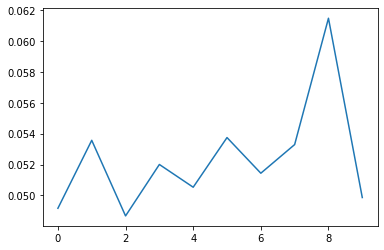

In [ ]:
plt.plot(loss)